We start by adding the necessary folders to the current working path.

In [1]:
# import sys, os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add 'TRA3D' folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TRA3D")

# Overview

In the following notebook we compute the $ \mathrm{\overline{TRA}} $ on the three-dimensional, steady ABC-flow. The velocity field is given as discrete dataset defined over the 3D meshgrid $ [0,2\pi]^3 $. The notebook is structured as follows:

1. Import data from the file 'ABCsteady.mat' stored in the folder 'data/ABC'.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Define integration scheme for computing flow map (=trajectories) and derivative of flow map (=velocities).
 <br />
5. $ \mathrm{\overline{TRA}} $:

    * Compute velocity along trajectories $ \lbrace \mathbf{\dot{x}}(t_{i}) \rbrace_{i=0}^N $ over the time interval $ [t_0, t_N] $.
    <br />
    
    * Compute $ \mathrm{\overline{TRA}} $ from velocity along trajectories:
    
    \begin{equation}
    \mathrm{\overline{TRA}}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \sum_{i = 0}^{N-1} \cos^{-1}\dfrac{\langle \mathbf{\dot{x}}(t_i), \mathbf{\dot{x}}(t_{i+1}) \rangle}{|\mathbf{\dot{x}}(t_i)||\mathbf{\dot{x}}(t_{i+1})|}
    \end{equation}

In [2]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/ABC/ABCsteady.mat')

U = mat_file['u'] # array (NY, NX, NZ)
V = mat_file['v'] # array (NY, NX, NZ)
W = mat_file['w'] # array (NY, NX, NZ)
x = mat_file['x'] # array (1, NX)
y = mat_file['y'] # array (1, NY)
z = mat_file['z'] # array (1, NZ))

# Computational parameters

Here we define the computational parameters.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 7 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = True # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = False # bool

# Defined domain
defined_domain = np.isfinite(U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 10 # float

# Time step-size
dt = 0.1 # float

# NOTE: For computing the backward FTLE field tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 200 # int
Nx = 200 # int
Nz = 200 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0] # float
dy = y_domain[1]-y_domain[0] # float
dz = z_domain[1]-z_domain[0] # float

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int
Nz = X_domain.shape[2] # int

# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations, we interpolate the discrete velocity data. The interpolation with respect to time and space is always linear.

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_steady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0
W[np.isnan(W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_steady(X, Y, Z, U, V, W)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# $ \mathrm{\overline{TRA}} $

The computation of the $ \mathrm{\overline{TRA}} $ is not done over the 3D meshgrid but only over the 2D faces of the cube $ [0,2\pi]^3 $.
We iterate over all initial conditions on the faces of the cube and calculate the velocity along the Lagrangian particle trajectories. We then compute the $ \mathrm{\overline{TRA}} $.

In [6]:
# Import function to compute trajectory/velocity along trajectory
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute trajectory rotation average (TRA)
from ipynb.fs.defs.TRA import _TRA

# Import package for parallel computing
from joblib import Parallel, delayed

def compute_TRA(x0, y0, z0):
    
    X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)
    
    DFdt = integration_dFdt(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady)[1] # array (Nt, 3, Nx*Ny*Nz)
    
    TRA = []
    
    for i in range(DFdt.shape[-1]):
            
        TRA.append(_TRA(DFdt[:,:,i].transpose(), time[-1]))
    
    return TRA

# Split x0,y0,z0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

## XY-plane

Compute $ \mathrm{\overline{TRA}} $ on XY-plane.

In [7]:
# XY-plane
x0_xy = X_domain[:,:,-1].ravel() # array (Nx*Ny*Nz, )
y0_xy = Y_domain[:,:,-1].ravel() # array (Nx*Ny*Nz, )
z0_xy = 0*np.ones(Nx*Ny,) # array (Nx*Ny*Nz, )

x0_batch = list(split(x0_xy, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_xy, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_xy, Ncores)) # list (Nx*Ny*Nz)

# Parallel computing
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_TRA)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on xy-plane
TRA_xy = results[0]
for res in results[1:]:
    TRA_xy = np.append(TRA_xy, res, axis = -1)

# Reshape arrays
X0_xy = np.array(x0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Y0_xy = np.array(y0_xy).reshape(Ny,Nx) # array (Ny, Nx)
Z0_xy = np.array(z0_xy).reshape(Ny,Nx) # array (Ny, Nx)
TRA_xy = np.array(TRA_xy).reshape(Ny,Nx) # array (Nt, Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    5.3s remaining:   13.1s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    5.3s finished


## XZ-plane

Compute $ \mathrm{\overline{TRA}} $ on XZ-plane.

In [8]:
# XZ-plane
x0_xz = X_domain[0,:,:].ravel() # array (Nx*Ny*Nz, )
y0_xz = 0*np.ones(Nx*Nz,) # array (Nx*Ny*Nz, )
z0_xz = Z_domain[0,:,:].ravel() # array (Nx*Ny*Nz, )

x0_batch = list(split(x0_xz, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_xz, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_xz, Ncores)) # list (Nx*Ny*Nz)

# Parallel computing
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_TRA)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on xz-plane
TRA_xz = results[0]
for res in results[1:]:
    TRA_xz = np.append(TRA_xz, res, axis = -1)
    
# Reshape arrays
X0_xz = np.array(x0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Y0_xz = np.array(y0_xz).reshape(Nz,Nx) # array (Nz, Nx)
Z0_xz = np.array(z0_xz).reshape(Nz,Nx) # array (Nz, Nx)
TRA_xz = np.array(TRA_xz).reshape(Nz,Nx) # array (Nt, Nz, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    4.8s remaining:   12.0s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    4.9s finished


## YZ-plane

Compute $ \mathrm{\overline{TRA}} $ on YZ-plane.

In [9]:
# YZ-plane
x0_yz = 0*np.ones(Ny*Nz,) # array (Nx*Ny*Nz, )
y0_yz = Y_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )
z0_yz = Z_domain[:,0,:].ravel() # array (Nx*Ny*Nz, )
    
x0_batch = list(split(x0_yz, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0_yz, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0_yz, Ncores)) # list (Nx*Ny*Nz)

# Parallel computing
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_TRA)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on yz-plane
TRA_yz = results[0]
for res in results[1:]:
    TRA_yz = np.append(TRA_yz, res, axis = -1)

# Reshape arrays
X0_yz = np.array(x0_yz).reshape(Nz,Ny) # array (Nt, Nz, Ny)
Y0_yz = np.array(y0_yz).reshape(Nz,Ny) # array (Nt, Nz, Ny)
Z0_yz = np.array(z0_yz).reshape(Nz,Ny) # array (Nt, Nz, Ny)
TRA_yz = np.array(TRA_yz).reshape(Nz,Ny) # array (Nz, Ny)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:    4.7s remaining:   11.8s
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:    4.8s finished


In [ ]:
############################################ PLOT RESULTS ############################################

# Import plotly for 3D figures
from plotly import graph_objs as go

# define minimum and maximum values for colorbar
min_value = min(np.min(TRA_yz),min(np.min(TRA_xy), np.min(TRA_xz)))
max_value = max(np.max(TRA_yz),max(np.max(TRA_xy), np.max(TRA_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = TRA_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = TRA_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = TRA_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy+2*np.pi, surfacecolor = TRA_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = TRA_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = TRA_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{\overline{{TRA}}}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Text(0.5, 1.0, '$x=0$ section')

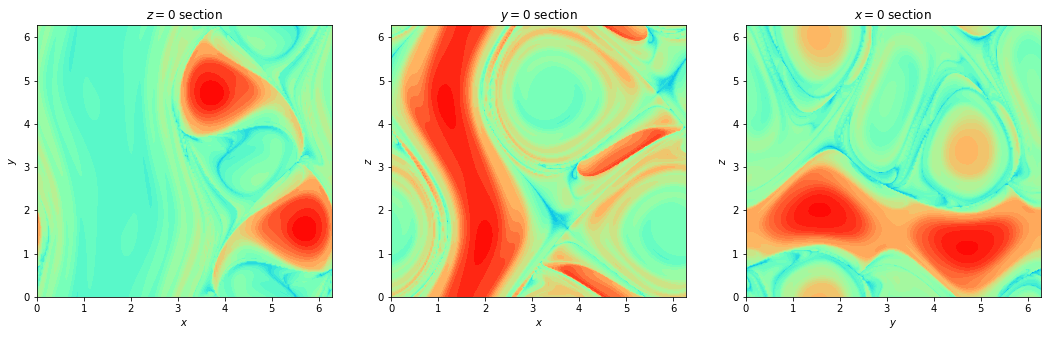

In [11]:
import matplotlib.pyplot as plt
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, TRA_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, TRA_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, TRA_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

Regions of high $ \mathrm{\overline{TRA}}_{t_0}^{t_N} $ are linked to vortical flow structures. Note that the $ \mathrm{\overline{TRA}} $ highlights the same vortical flow areas as the [LAVD](../../LAVD3D/Main/LAVDABCsteady.ipynb). In order to test the ability of the $ \mathrm{\overline{TRA}} $ to extract vortical flow regions even in a sparse data setting, we randomly progressively downsample the trajectory data.

# Random subsampling

As shown in the following figures, $ \mathrm{\overline{TRA}} $ is able to capture the major lagrangian eddies even at very low resolutions.

## 10% subsampling

In [12]:
# import random number generator
import random

# 10% subsampling
rdn10 = random.sample(range(0, Nx*Ny), int(Nx*Ny/10))

# Subsample initial grid and TRA field (=subsample trajectories) on XY-plane
x_XY_subsampled10 = X0_xy.ravel()[rdn10] # array (Nx*Ny/10, )
y_XY_subsampled10 = Y0_xy.ravel()[rdn10] # array (Nx*Ny/10, )
TRA_XY_subsampled10 = TRA_xy.ravel()[rdn10] # array (Nx*Ny/10, )

# Subsample initial grid and TRA field (=subsample trajectories) on XZ-plane
x_XZ_subsampled10 = X0_xz.ravel()[rdn10] # array (Nx*Ny/10, )
y_XZ_subsampled10 = Z0_xz.ravel()[rdn10] # array (Nx*Ny/10, )
TRA_XZ_subsampled10 = TRA_xz.ravel()[rdn10] # array (Nx*Ny/10, )

# Subsample initial grid and TRA field (=subsample trajectories) on YZ-plane
x_YZ_subsampled10 = Y0_yz.ravel()[rdn10] # array (Nx*Ny/10, )
y_YZ_subsampled10 = Z0_yz.ravel()[rdn10] # array (Nx*Ny/10, )
TRA_YZ_subsampled10 = TRA_yz.ravel()[rdn10] # array (Nx*Ny/10, )

# Import interpolant for scatter interpolation
from scipy.interpolate import Rbf

# Compute Interpolant
interp10_XY = Rbf(x_XY_subsampled10, y_XY_subsampled10, TRA_XY_subsampled10, function = "linear")
interp10_XZ = Rbf(x_XZ_subsampled10, y_XZ_subsampled10, TRA_XZ_subsampled10, function = "linear")
interp10_YZ = Rbf(x_YZ_subsampled10, y_YZ_subsampled10, TRA_YZ_subsampled10, function = "linear")

# Re-evaluate interpolant over original (initial) meshgrid
TRA_interpolated10_xy = interp10_XY(X0_xy, Y0_xy) 
TRA_interpolated10_xz = interp10_XZ(X0_xz, Z0_xz) 
TRA_interpolated10_yz = interp10_YZ(Y0_yz, Z0_yz)

In [ ]:
############################################ PLOT RESULTS ############################################

# define minimum and maximum values for colorbar
min_value = min(np.min(TRA_yz),min(np.min(TRA_xy), np.min(TRA_xz)))
max_value = max(np.max(TRA_yz),max(np.max(TRA_xy), np.max(TRA_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = TRA_interpolated10_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = TRA_interpolated10_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = TRA_interpolated10_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy+2*np.pi, surfacecolor = TRA_interpolated10_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = TRA_interpolated10_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = TRA_interpolated10_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{\overline{{TRA}}}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Text(0.5, 1.0, '$x=0$ section')

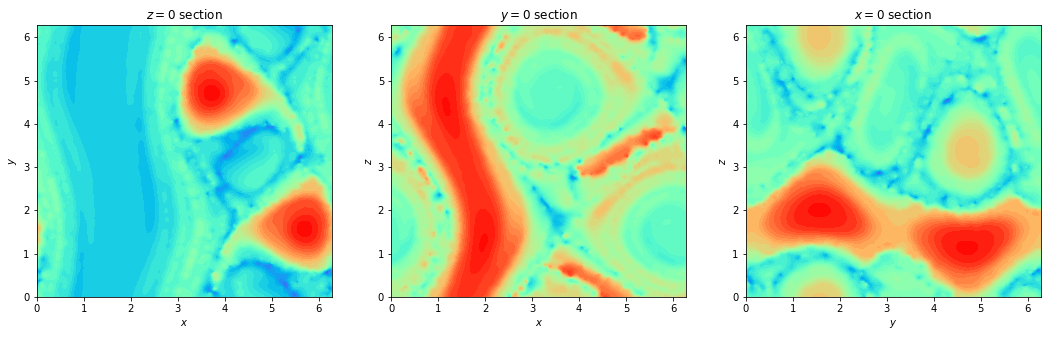

In [13]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, TRA_interpolated10_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, TRA_interpolated10_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, TRA_interpolated10_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

## 1% subsampling

In [14]:
# 1% subsampling
rdn100 = random.sample(range(0, Nx*Ny), int(Nx*Ny/100))

# Subsample initial grid and TRA field (=subsample trajectories) on XY-plane
x_XY_subsampled100 = X0_xy.ravel()[rdn100] # array (Nx*Ny/10, )
y_XY_subsampled100 = Y0_xy.ravel()[rdn100] # array (Nx*Ny/10, )
TRA_XY_subsampled100 = TRA_xy.ravel()[rdn100] # array (Nx*Ny/10, )

# Subsample initial grid and TRA field (=subsample trajectories) on XZ-plane
x_XZ_subsampled100 = X0_xz.ravel()[rdn100] # array (Nx*Ny/10, )
y_XZ_subsampled100 = Z0_xz.ravel()[rdn100] # array (Nx*Ny/10, )
TRA_XZ_subsampled100 = TRA_xz.ravel()[rdn100] # array (Nx*Ny/10, )

# Subsample initial grid and TRA field (=subsample trajectories) on YZ-plane
x_YZ_subsampled100 = Y0_yz.ravel()[rdn100] # array (Nx*Ny/10, )
y_YZ_subsampled100 = Z0_yz.ravel()[rdn100] # array (Nx*Ny/10, )
TRA_YZ_subsampled100 = TRA_yz.ravel()[rdn100] # array (Nx*Ny/10, )

# Compute Interpolant
interp100_XY = Rbf(x_XY_subsampled100, y_XY_subsampled100, TRA_XY_subsampled100, function = "linear")
interp100_XZ = Rbf(x_XZ_subsampled100, y_XZ_subsampled100, TRA_XZ_subsampled100, function = "linear")
interp100_YZ = Rbf(x_YZ_subsampled100, y_YZ_subsampled100, TRA_YZ_subsampled100, function = "linear")

# Re-evaluate interpolant over original (initial) meshgrid
TRA_interpolated100_xy = interp100_XY(X0_xy, Y0_xy) 
TRA_interpolated100_xz = interp100_XZ(X0_xz, Z0_xz) 
TRA_interpolated100_yz = interp100_YZ(Y0_yz, Z0_yz)

In [ ]:
############################################ PLOT RESULTS ############################################

# define minimum and maximum values for colorbar
min_value = min(np.min(TRA_yz),min(np.min(TRA_xy), np.min(TRA_xz)))
max_value = max(np.max(TRA_yz),max(np.max(TRA_xy), np.max(TRA_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = TRA_interpolated100_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = TRA_interpolated100_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = TRA_interpolated100_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy+2*np.pi, surfacecolor = TRA_interpolated100_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = TRA_interpolated100_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = TRA_interpolated100_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{\overline{{TRA}}}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Text(0.5, 1.0, '$x=0$ section')

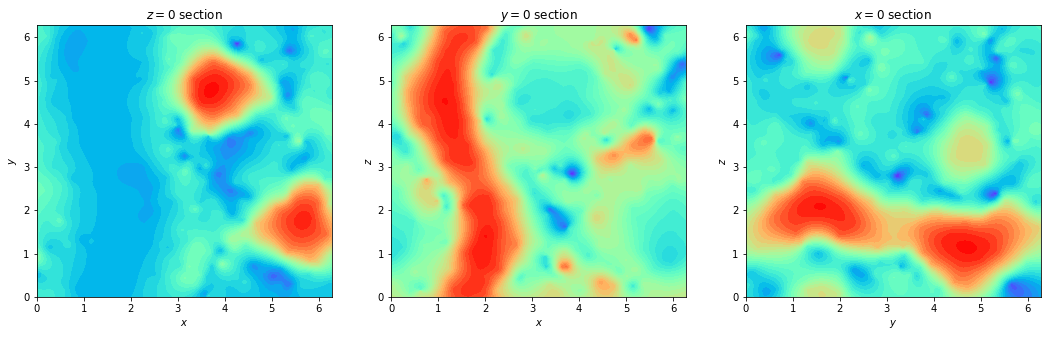

In [15]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, TRA_interpolated100_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, TRA_interpolated100_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, TRA_interpolated100_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

## 0.1% subsampling

In [16]:
# 0.1% subsampling
rdn1000 = random.sample(range(0, Nx*Ny), int(Nx*Ny/1000))

# Subsample initial grid and TRA field (=subsample trajectories) on XY-plane
x_XY_subsampled1000 = X0_xy.ravel()[rdn1000] # array (Nx*Ny/10, )
y_XY_subsampled1000 = Y0_xy.ravel()[rdn1000] # array (Nx*Ny/10, )
TRA_XY_subsampled1000 = TRA_xy.ravel()[rdn1000] # array (Nx*Ny/10, )

# Subsample initial grid and TRA field (=subsample trajectories) on XZ-plane
x_XZ_subsampled1000 = X0_xz.ravel()[rdn1000] # array (Nx*Ny/10, )
y_XZ_subsampled1000 = Z0_xz.ravel()[rdn1000] # array (Nx*Ny/10, )
TRA_XZ_subsampled1000 = TRA_xz.ravel()[rdn1000] # array (Nx*Ny/10, )

# Subsample initial grid and TRA field (=subsample trajectories) on YZ-plane
x_YZ_subsampled1000 = Y0_yz.ravel()[rdn1000] # array (Nx*Ny/10, )
y_YZ_subsampled1000 = Z0_yz.ravel()[rdn1000] # array (Nx*Ny/10, )
TRA_YZ_subsampled1000 = TRA_yz.ravel()[rdn1000] # array (Nx*Ny/10, )

# Compute Interpolant
interp1000_XY = Rbf(x_XY_subsampled1000, y_XY_subsampled1000, TRA_XY_subsampled1000, function = "linear")
interp1000_XZ = Rbf(x_XZ_subsampled1000, y_XZ_subsampled1000, TRA_XZ_subsampled1000, function = "linear")
interp1000_YZ = Rbf(x_YZ_subsampled1000, y_YZ_subsampled1000, TRA_YZ_subsampled1000, function = "linear")

# Re-evaluate interpolant over original (initial) meshgrid
TRA_interpolated1000_xy = interp1000_XY(X0_xy, Y0_xy) 
TRA_interpolated1000_xz = interp1000_XZ(X0_xz, Z0_xz) 
TRA_interpolated1000_yz = interp1000_YZ(Y0_yz, Z0_yz)

In [ ]:
############################################ PLOT RESULTS ############################################

# define minimum and maximum values for colorbar
min_value = min(np.min(TRA_yz),min(np.min(TRA_xy), np.min(TRA_xz)))
max_value = max(np.max(TRA_yz),max(np.max(TRA_xy), np.max(TRA_xz)))

# create figure
fig = go.Figure(data=[go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy, surfacecolor = TRA_interpolated1000_xy, showscale = True, colorscale='rainbow', cmin=min_value, cmax=max_value)])
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz, z = Z0_xz, surfacecolor = TRA_interpolated1000_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz, y = Y0_yz, z = Z0_yz, surfacecolor = TRA_interpolated1000_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xy, y = Y0_xy, z = Z0_xy+2*np.pi, surfacecolor = TRA_interpolated1000_xy, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_xz, y = Y0_xz+2*np.pi, z = Z0_xz, surfacecolor = TRA_interpolated1000_xz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))
fig.add_trace(go.Surface(x = X0_yz+2*np.pi, y = Y0_yz, z = Z0_yz, surfacecolor = TRA_interpolated100_yz, showscale = False, colorscale='rainbow', cmin=min_value, cmax=max_value))

# camera
camera = dict(eye=dict(x=-1.45,y=-1.45,z=1.7))
fig.update_layout(scene_camera=camera)

fig.update_layout(
    title={
        'text': f'$\mathrm{{\overline{{TRA}}}}_{t0}^{{{tN}}}$',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Text(0.5, 1.0, '$x=0$ section')

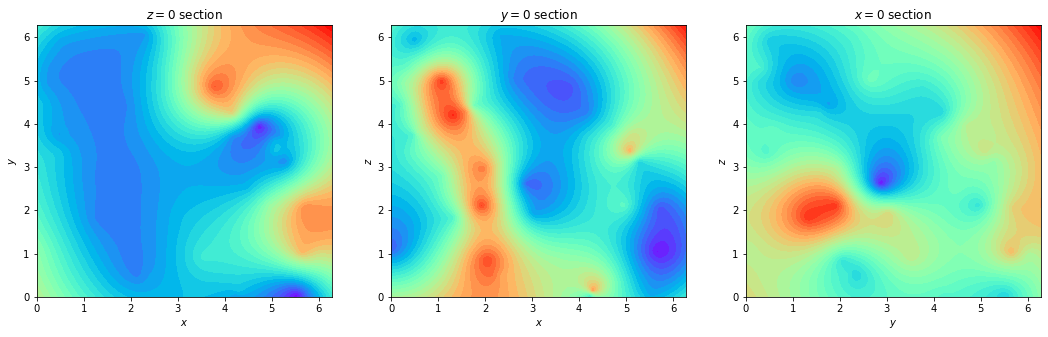

In [17]:
f,axes = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 5))
cmapToUse = 'rainbow'
nContours = 40

axes[0].contourf(x_domain, y_domain, TRA_interpolated1000_xy, nContours,  cmap = cmapToUse)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_title('$z=0$ section')

axes[1].contourf(x_domain, z_domain, TRA_interpolated1000_xz, nContours,  cmap = cmapToUse)
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$z$')
axes[1].set_title('$y=0$ section')


axes[2].contourf(y_domain, z_domain, TRA_interpolated1000_yz, nContours,  cmap = cmapToUse)
axes[2].set_xlabel('$y$')
axes[2].set_ylabel('$z$')
axes[2].set_title('$x=0$ section')

Elliptic LCS are visible as convex tubular surfaces with a sharp drop in the $ \mathrm{\overline{TRA}} $-field. The structures highlighted by the $ \mathrm{LAVD} $-field can directly be compared to those of the [$ \mathrm{\overline{LAVD}}$](../../LAVD3D/Main/LAVDABCsteady.ipynb)-field. Contrary to other commonly used elliptic LCS detection methods such as the $ \mathrm{\overline{LAVD}}$, the features of $ \mathrm{\overline{TRA}} $ are robust with respect to subsampling as the main vortical flow features are preserved even in a very sparse setting.

# References

[1] Haller, G., Aksamit, N., & Encinas-Bartos, A. P. (2021). Quasi-objective coherent structure diagnostics from single trajectories. Chaos: An Interdisciplinary Journal of Nonlinear Science, 31(4), 043131.

[2] Notebook 5.5.4 in "Transport Barriers and Coherent Structures in Flow Data" by George Haller